In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')

In [3]:
b = 0.1
E = 30.0*1e9
P = 30000.0
p = 2150.0
L = 5.0
a = 2
g = 9.81

In [4]:
def h(x):
    return 0.1 + x / (10*L)

def A(x):
    return b*h(x)

In [5]:
def C(x):
    return E*A(x)

In [6]:
def f(x):
    return p*g*A(x)

In [7]:
def u0():
    return 0

In [8]:
def du(x):
    return -P/(E*A(x))

In [9]:
def u_exact(x):
    return f(x)/C(x)*x*x/2+(-P/(C(x))-(f(x))/C(x)*L)*x

In [10]:
def psi(x, i, x_i, N):
    # считаем пси
    # подаем точку x, а также порядковый номер конечного элемента i
    # также подаем исходный массив иксов x_i и количество конечных элментов N
    if (i==0): # если первый конечный элемент
        if(x<=x_i[1]):
            return (x_i[1]-x)/(x_i[1]-x_i[0])
        else:
            return 0
    elif (i==N): # если последний конечный элемент
        if(x>x_i[N-1]):
            return (-x_i[N-1]+x)/(x_i[N]-x_i[N-1])
        else:
            return 0
    else:
        if((x>x_i[i-1]) & (x<=x_i[i])):
            return (-x_i[i-1]+x)/(x_i[i]-x_i[i-1])
        elif((x>x_i[i]) & (x<=x_i[i+1])):
            return (x_i[i+1]-x)/(x_i[i+1]-x_i[i])
        else:  
            return 0   
def u_out(u_m, x, x_i, N): # возвращаем рассчитанное значение искривления балки
    ans = 0
    for i in range(len(u_m)):
        ans+= psi(x, i, x_i, N)*u_m[i]
    return ans
def calculate(N):
    time1 = time.time()
    
    x_i = np.linspace(0,L,N+1) # иксы наших конечных элементов
    
    A_m = np.zeros((N+1)*(N+1)).reshape(N+1,N+1)
    for i in range(1,N+1):
        A_m[i][i]+=1.0
        A_m[i-1][i-1]+=1.0
        A_m[i][i-1]-=1.0
        A_m[i-1][i]-=1.0
    A_m[0] = np.zeros(N+1)
    A_m[0][0] = 1
    
    def newC():
        C_ = np.zeros((N+1)*(N+1)).reshape(N+1,N+1)
        for i in range(N+1):
            for j in range(N+1):
                C_[i][j] = C(j*L/N)*A_m[i][j]
        return C_
    
    A_m = newC()*N/L
    
    cond_A = np.linalg.cond(A_m)
    R_ = np.zeros(len(x_i))
    Q = 10000
    for s in range(0,N+1):
        # от x_s до x_s+1
        x_new = 0
        y_new = 0
        if(s<N):
            x_razbienie = np.linspace(x_i[s],x_i[s+1],Q)
            h_new = x_razbienie[1] - x_razbienie[0]
            for j in range(len(x_razbienie)-1):
                x_new += h_new*f(x_razbienie[j])*((x_razbienie[j]-x_i[s+1])/(x_i[s]-x_i[s+1])+
                               (x_razbienie[j+1]-x_i[s+1])/(x_i[s]-x_i[s+1]))/2

                y_new += h_new*f(x_razbienie[j])*((-x_razbienie[j]+x_i[s])/(x_i[s]-x_i[s+1])+
                               (-x_razbienie[j+1]+x_i[s])/(x_i[s]-x_i[s+1]))/2     
            R_[s]+=-x_new
            R_[s+1]+=-y_new
        R_[s]+= du(L)*C(L)*psi(L,s, x_i, N)
    R_[0] = 0
    
    ans = np.linalg.inv(A_m).dot(R_)
    
    time2 = time.time()
    out_time = time2 - time1
    x_new = np.linspace(0,L,Q)
    y_new = [u_out(ans, i, x_i, N) for i in x_new]
    y_new = np.array(y_new)
    y_old = [u_exact(i) for i in x_new]
    y_old = np.array(y_old)
    
    E1 = (np.abs((y_new-y_old)).max()/np.abs(y_old).max())
    
    suma_up = 0
    suma_down = 0
    h = x_new[1]-x_new[0]
    for i in range(len(x_new)-1):
        suma_up+= ((u_exact(x_new[i])-u_out(ans,x_new[i], x_i, N))**2+(u_exact(x_new[i+1])-u_out(ans,x_new[i+1], x_i, N))**2)#/2
        suma_down+=(u_exact(x_new[i])**2+u_exact(x_new[i+1])**2)#/2
    E2 = (np.sqrt(suma_up/suma_down))
    
    y_new = [u_out(ans, i, x_i, N) for i in x_i]
    
    plot_data = {
        'x_tochn': x_new,
        'x_pribl': x_i,
        'tochn': y_old,
        'pribl': y_new,
    }
    return cond_A, E1, E2, out_time, plot_data, N

def plot_graphic(plot_data, N):
    plt.subplots(figsize=(7,7))
    plt.plot(plot_data['x_tochn'], plot_data['tochn'] ,lw=4,alpha=0.9, label='Точное решение')
    plt.plot(plot_data['x_pribl'], plot_data['pribl'] ,lw=2,ls='--', marker='o',ms=15/np.log2(N), label=f'МКЭ N={N}')
    #plt.legend()
    plt.xlabel("x", size=20)
    plt.ylabel("u", size=20)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.legend(prop={'size': 15})

In [11]:
dict_ = {
    "N": [1],
    "cond_A": [0],
    "E1": [0],
    'E2': [0],
    "time": [0]
} # заполняем табличку

for i in [2**i for i in range(1, 9)]:
    returned = calculate(i)
    dict_['N'].append(i)
    dict_['cond_A'].append(returned[0])
    dict_['E1'].append(returned[1])
    dict_['E2'].append(returned[2])
    dict_['time'].append(returned[3])
pd.DataFrame(dict_)

,N,cond_A,E1,E2,time
0,1,0.000000,0.000000,0.000000,0.000000
1,2,7.748237,0.066314,0.054609,0.065758
2,4,28.158056,0.020362,0.013626,0.125667
3,8,112.349443,0.006074,0.004341,0.251628
4,16,459.712193,0.005669,0.003985,0.505284
5,32,1882.377188,0.005660,0.004203,1.021929
6,64,7671.493268,0.005660,0.004275,2.013315
7,128,31108.815390,0.005660,0.004294,4.022686
8,256,125634.118838,0.005660,0.004299,8.068878


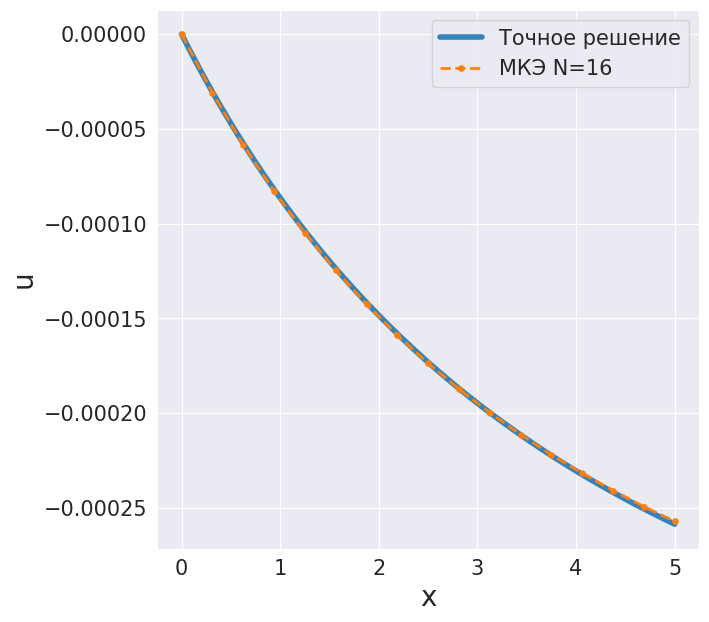

In [12]:
N = 16
returned = calculate(N)
plot_graphic(returned[4], returned[5])